 CNN for Document Quality for Intuit Senior Design 
 Written By Taha Jalali
 
 To use this code make sure DATADIR point to the file W2 on your local system
 W2 folder will contain a Good and Bad folder that contain good quality images and bad quality images 
 This double loop will make sure we can get to the images and show how we will convert an image to an array 
 We are also converting the image to grayscale 
 
 *Break points are so we can see how the image looks like 

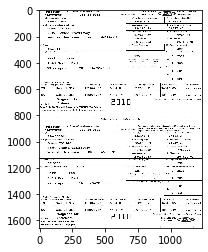

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2

DATADIR = "/Users/macbook/OCR/W2"
CATEGORIES = ["Good", "Bad"]

for c in CATEGORIES: # c will be Good then Bad 
    path = os.path.join(DATADIR, c) # adds it to the path so we can access file
    for img in os.listdir(path): # loops threw each image 
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # converts that image to an array/grayscale
        plt.imshow(img_array, cmap="gray") # will print one out to see how it looks 
        plt.show()
        break
    break

This cell it just to let us know the type of the image and get an idea of image size

In [2]:
im = cv2.imread('/Users/macbook/OCR/W2/Good/W2_XL_input_clean_1000.jpg') # reads a single image 

print(type(im)) # what type is that image 
# <class 'numpy.ndarray'>

print(im.shape) # size of that image 
print(type(im.shape)) 
#(1658, 1236, 3)  # 3 stands for RGB 
#<class 'tuple'>



<class 'numpy.ndarray'>
(1658, 1236, 3)
<class 'tuple'>


Original I wanted to make sure all images are 1600x1200 in size BUT it look like it slowed down the training and crased, Still need to figure out why 

Reshape them to 200x200 for each document but not sure if that will effect the results in a negative way 
We also print the image to see how it will look with matplot


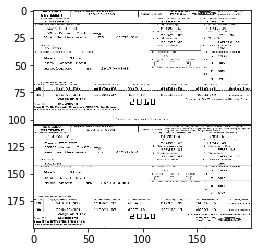

In [3]:
IMG_SIZE_HEIGHT = 1600 # Not using
IMG_SIZE_WIDTH = 1200  # Not using 
IMG_SIZE = 200         # This is the size we are using 

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # reshape the images 
plt.imshow(new_array, cmap = 'gray')
plt.show()

Now we are going to make our training data set 
We loop threw all the images converting them into an array 
Depending of which folder they are in we will label them 

Try block to handle an images that will throw an error, will pass for not But might want to see what images 
are giving us issues 


In [4]:
training_data = []
IMG_SIZE_HEIGHT = 1600  # not using 
IMG_SIZE_WIDTH = 1200   # not using 
IMG_SIZE = 200         # This is the size we are using 

def create_training_data():
    for category in CATEGORIES:                 # loop threw each folder with in W2 folder  
        path = os.path.join(DATADIR,category)   # Path to folder 
        class_num = CATEGORIES.index(category)  # labeling the data based on folder 
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # converts the image to an array 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)   # Resize to normalize data size 
                training_data.append([new_array, class_num]) # adds it to are traning data with the label 
            except Exception as e:
                pass
            
create_training_data()

In [6]:
# traning data is in order of good and bad so need to shuffle for the CNN
import random 
random.shuffle(training_data)

In [5]:
print(len(training_data)) # size of our traning data 

3735


We create our X and y arrays 
X will contain the features and y will be our labels(good or bad)
MUST make sure both are numpy array, Keras will throw error if not 

In [8]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)


In [9]:
# this is for if we want to save our data 
# issue with full size images saying there to big (works with size 200)
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

Now it time to train our model

We start by normalizing the data by scaling it, min is 0 and max is 255 for pixel data 
So we will divide it by 255, Keras also has a built in function to do this

Our model will be Sequential 

First layer is 64 with a window size of 3,3
The activation function is rectified linear (relu)
and finaly a pooling size of 2 by 2

2nd layer will be the same as layer one 

Then we will flatten the data since the Convolutional is in 2D and that dense layer need a 1D

Layer 3 will be the Dense layer of size 64

Layer 4 will be our last layer with size 1 (Good or bad)
and its activation layer will be the Sigmoid function 


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

X = X/255 #255 pixels max for pixel data 

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# have to flatten b/c Convolutional is 2D and dense layer want a 1D
model.add(Flatten()) 

model.add(Dense(64))

# output layer 
model.add(Dense(1))
model.add(Activation('sigmoid'))


Now to comile and run model, Since this is a binary output(Good or Bad) we can use Binary Crossentropy But we can later use Categorical Crossentropy if we want to later narrow down the issues with bad images,
Optimizer is Adam and we want to measure accuracy 
We run with epochs of 3 but look like we might not need so many 
Currently sending 12 at a time with a validation split of 10%

In [14]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
model.fit(X, y, batch_size=12, epochs = 3 , validation_split = 0.1)

Train on 3361 samples, validate on 374 samples
Epoch 1/3
3361/3361 [==============================] - 149s 44ms/sample - loss: 0.1621 - accuracy: 0.9530 - val_loss: 0.1218 - val_accuracy: 0.9626
Epoch 2/3
3361/3361 [==============================] - 143s 43ms/sample - loss: 0.1294 - accuracy: 0.9667 - val_loss: 0.4896 - val_accuracy: 0.9118
Epoch 3/3
3361/3361 [==============================] - 142s 42ms/sample - loss: 0.1214 - accuracy: 0.9658 - val_loss: 0.1199 - val_accuracy: 0.9733
